# 1.Kütüphaneler

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from dowhy import CausalModel
import dowhy.datasets

# 2.Giriş

Dowhy, nedensel çıkarım için iki güçlü çerçeveyi, yani grafiksel nedensel modelleri (graphical causal models-GCM) ve potansiyel çıktıları (potential outcomes-PO) birleştiren basit bir birleştirici dile dayanmaktadır. Varsayımları modellemek ve parametrik olmayan bir nedensel etkiyi tanımlamak için grafik tabanlı kriterleri ve hesaplamayı kullanır.

## 2.1.Etki Çıkarımı

Etki tahmini için dowhy, öncelikle potansiyel çıktılara dayalı yöntemlere geçiş yapar. Bunu yapmak için dowhy, nedensel bir modelin modellenmesi (model), tanımlama (identification), tahmin (estimation) ve çürütmeden (refutation) oluşan 4 adımlı basit bir şablon sunar:

In [2]:
# Generate some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000)

In [4]:
data['df'].head()

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.0,0.816180,-0.175936,1.352527,1.118127,-0.484304,-1.699207,True,14.615574
1,1.0,0.486884,-0.484943,1.337005,2.703590,-2.019965,0.921646,True,19.461043
2,1.0,0.640840,0.116950,2.254334,0.474570,1.908435,-0.627697,True,23.094921
3,1.0,0.229134,-0.911388,1.149583,1.180727,0.244666,1.528083,True,20.288529
4,1.0,0.774845,-1.120933,1.057648,1.303295,-2.242855,-1.694312,True,10.722622


In [3]:
# Step 1: Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

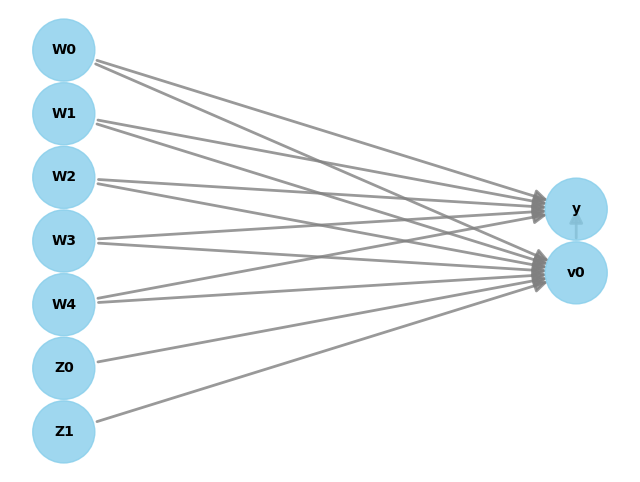

In [11]:
model.view_model()

In [5]:
# Step 2: Identify causal effect and return target estimands
identified_estimand = model.identify_effect()

In [6]:
# Step 3: Estimate the target estimand using a statistical method.
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching")

In [7]:
# Step 4: Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="random_common_cause")

Bu dört adımın ne anlama geldiğini (ve neden dört adıma ihtiyacımız olduğunu) anlamak için daha fazla bilgi edinebileceğiniz en iyi yer kullanıcı kılavuzunun Nedensel Etkileri Tahmin Etme bölümüdür. Alternatif olarak, kodu derinlemesine inceleyebilir ve Nedensel Etkiyi Hesaplamak için Temel Örnek'teki temel özellikleri keşfedebilirsiniz.

## 2.2. Grafiksel Nedensel Model-Bazlı Çıkarım

Kök neden analizi, noktasal karşı olgusal çıkarım, yapısal analiz ve benzeri özellikler için dowhy, grafiksel nedensel modelleri kullanır. Grafiksel nedensel modellerin dili yine yanıtlanabilecek çeşitli nedensel sorular sunmaktadır. Dowhy'ın bu nedensel soruları yanıtlayan API'si aşağıdaki gibi 3 adımlı basit bir akışı takip eder:

In [12]:
import networkx as nx
from dowhy import gcm

In [13]:
# Let's generate some "normal" data we assume we're given from our problem domain:
X = np.random.normal(loc=0, scale=1, size=1000)
Y = 2 * X + np.random.normal(loc=0, scale=1, size=1000)
Z = 3 * Y + np.random.normal(loc=0, scale=1, size=1000)
data = pd.DataFrame(dict(X=X, Y=Y, Z=Z))

In [14]:
# Step 1: Model our system:
causal_model = gcm.StructuralCausalModel(nx.DiGraph([('X', 'Y'), ('Y', 'Z')]))
gcm.auto.assign_causal_mechanisms(causal_model, data)

In [15]:
# Step 2: Train our causal model with the data from above:
gcm.fit(causal_model, data)

Fitting causal mechanism of node Z: 100%|██████████| 3/3 [00:00<00:00, 854.93it/s]


In [16]:
# Step 3: Perform a causal analysis. For instance, root cause analysis, where we observe
anomalous_sample = pd.DataFrame(dict(X=[0.1], Y=[6.2], Z=[19]))  
# Here, Y is the root cause.
# ... and would like to answer the question:
# "Which node is the root cause of the anomaly in Z?":
anomaly_attribution = gcm.attribute_anomalies(causal_model, "Z", anomalous_sample)

Evaluate set function: 8it [00:00, ?it/s]


Bu ve diğer GCM özellikleri hakkında daha fazla bilgi edinmek istiyorsanız kullanıcı kılavuzundaki Grafiksel Nedensel Modellerin (GCM'ler) Modellenmesi ile başlamanızı veya Grafiksel Nedensel Modeller için Temel Örnek'e göz atmanızı öneririz.

## 2.3. Nedensel Çıkarım için İhtiyaç

Nedensel çıkarım, tahmine dayalı modellerde bulunan basit ilişkilerin ötesinde gerçek veri oluşturma süreçlerini ortaya çıkardığı için bilinçli karar verme için gereklidir. Müdahale (intervention) verilerinin yokluğunda bile müdahalelerin etkilerini ve karşı olgusal (counterfactual) sonuçları tahmin etmemizi sağlar. Korelasyona dayalı analizin ötesine geçmek, içgörüleri genelleştirmek ve gerçek dünya ilişkileri hakkında gerçek bir anlayış kazanmak için hayati öneme sahiptir. Örneğin sağlık, eğitim ve yönetişim gibi toplumsal açıdan kritik alanlara aktif olarak müdahale eden bilgi işlem sistemleri için, bu müdahalelerin nedensel etkilerini doğru bir şekilde tahmin etmek ve anlamak önemlidir. Aşağıda karar vermede nedensel çıkarım gerektiren bazı genel soruları açıklıyoruz:

* İşe yarayacak mı?
  - Bir sistemde önerilen bir değişiklik insanların sonuçlarını iyileştirir mi?
* Neden işe yaradı?
  - Bir sistemin sonucunda bir değişikliğe ne yol açtı?
* Ne yapmalıyız?
  - Bir sistemdeki hangi değişikliklerin insanlar açısından sonuçları iyileştirmesi muhtemeldir?
* Genel etkiler nelerdir?
  - Sistem insan davranışıyla nasıl etkileşime giriyor?
  - Bir sistemin tavsiyelerinin insanların faaliyetleri üzerindeki etkisi nedir?

Nedensel çıkarım için önerilen birçok yöntem olmasına rağmen, temel zorluk bu farklı yöntemlerin varsayımlarını karşılaştırmak ve sonuçların sağlamlığını kontrol etmektir. Bu amaçla dowhy, nedensel varsayımların açık modellemesini ve test edilmesini destekleyen, nedensel çıkarımlara yönelik bir Python kütüphanesidir. Dowhy üç katkıda bulunur:

* Temeldeki tüm varsayımların açıkça belirtilmesini ve şeffaf olmasını sağlayarak, grafiksel gösterimler yoluyla nedensel ilişkileri modellemek için sistematik bir yöntem sağlar.
* Grafiksel modeller ve potansiyel sonuçlardan oluşan iki ana çerçeveyi birleştirerek birçok popüler nedensel çıkarım yöntemi için birleşik bir arayüz sağlar.
* Mümkünse varsayımların geçerliliğini test etme yetenekleri sağlar ve tahminin ihlallere karşı sağlamlığını değerlendirir.